# Deep Neural Network for Cat Image Classification

Purpose is to build a deep network, and apply it to cat vs non-cat classification.  

Let's get started!

## 1 - Packages

Let's first import all the packages that we'll use: 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test the model with our own picture at the end.

In [10]:
# Importing the packages
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Defining how to load data from h5 file format to numpy array
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # test set labels

    classes = np.array(test_dataset['list_classes'][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



## 2 - Dataset

**Problem Statement**: Given a dataset ('data.h5') containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [11]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


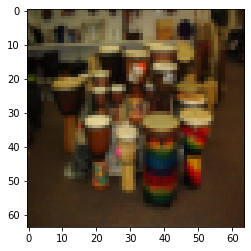

In [12]:
# Example of a picture
index = 5  # Feel free to change the index to view any piture in the dataset
plt.imshow(train_x_orig[index])
print ('y = ' + str(train_y[0,index]) + '. It\'s a ' + classes[train_y[0,index]].decode('utf-8') +  ' picture.')

In [13]:
# Exploring the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ('Number of training examples: ' + str(m_train))
print ('Number of testing examples: ' + str(m_test))
print ('Each image is of size: (' + str(num_px) + ', ' + str(num_px) + ', 3)')
print ('train_x_orig shape: ' + str(train_x_orig.shape))
print ('train_y shape: ' + str(train_y.shape))
print ('test_x_orig shape: ' + str(test_x_orig.shape))
print ('test_y shape: ' + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [14]:
# Reshaping the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The '-1' makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardizing data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ('train_x\'s shape: ' + str(train_x.shape))
print ('test_x\'s shape: ' + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - L-layer Neural Network

In [15]:
# Initializing Parameters
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters 'W1', 'b1', ..., 'WL', 'bL':
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters



# Linear Part of Single Layer's Activation
def linear_forward(A, W, b):
    """
    Implements the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing 'A', 'W' and 'b' ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache



# Defining Sigmoid Function
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache



# Defining ReLu Function
def relu(Z):
    """
    Implements the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing 'A' ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



# Defining ReLu for backward propogation (Derivative of ReLu)
def relu_backward(dA, cache):
    """
    Implements the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
     
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ



# Defining Sigmoid for backward Propagation (Derivative of Sigmoid)
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ



# Activation Function
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: 'sigmoid' or 'relu'

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing 'linear_cache' and 'activation_cache';
             stored for computing the backward pass efficiently
    """
    
    if activation == 'sigmoid':
        # Inputs: 'A_prev, W, b'. Outputs: 'A, activation_cache'.
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == 'relu':
        # Inputs: 'A_prev, W, b'. Outputs: 'A, activation_cache'.
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache



# Forward Propagation
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add 'cache' to the 'caches' list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = 'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add 'cache' to the 'caches' list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = 'sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches



# Computing Cost
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true 'label' vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost



# Liner Part of Single Layer's Backward Propagation
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db



# Activation Function for Backward Propagation
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: 'sigmoid' or 'relu'
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db



# Backward Propagation
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true 'label' vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with 'relu' (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with 'sigmoid' (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads['dA' + str(l)] = ... 
             grads['dW' + str(l)] = ...
             grads['db' + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: 'AL, Y, caches'. Outputs: 'grads['dAL'], grads['dWL'], grads['dbL']
    current_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, current_cache, activation = 'sigmoid')
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA' + str(l + 1)], current_cache, activation = 'relu')
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l + 1)] = dW_temp
        grads['db' + str(l + 1)] = db_temp

    return grads



# Updating Parameters (Gradient Descent)
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(l)] = ... 
                  parameters['b' + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters['W' + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]
        
    return parameters



# Model for L-Layer Deep Neural Network
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0005, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true 'label' vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters Initialization (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward Propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Computing Cost
        cost = compute_cost(AL, Y)

        # Backward Propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Printing the cost every 500 training example
        if print_cost and i % 500 == 0:
            print ('Cost after iteration %i: %f' %(i, cost))
            if i == 0:
                pass
            else:
                print('--- %s total seconds ---' % (time.time() - start_time_in))
        if print_cost and i % 500 == 0:
            costs.append(cost)
            start_time_in = time.time()

            
    # Plotting the Cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters



# Prediction Algo
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward Propagation
    probas, caches = L_model_forward(X, parameters)

    
    # Converting Probabilities to 0/1 Predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    print ('predictions: ' + str(p))
    print ('true labels: ' + str(y))
    print('Accuracy: '  + str(np.sum((p == y)/m)))
        
    return p

Cost after iteration 0: 0.678243
Cost after iteration 500: 0.323677
--- 30.15203285217285 total seconds ---
Cost after iteration 1000: 0.060460
--- 34.027860164642334 total seconds ---


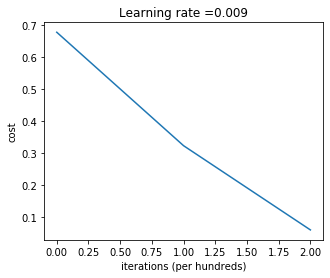

--- 98.09313607215881 total seconds ---


In [28]:
# Defining number of layers and number of neurons (nodes) in each row
layers_dims = [12288, 64, 8, 1] # 4 layer model

# Running the model
start_time = time.time()

parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.009, num_iterations = 1500, print_cost = True)

print('--- %s total seconds ---' % (time.time() - start_time))

In [29]:
# Prediction on Training Set
pred_train = predict(train_x, train_y, parameters)

predictions: [[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
true labels: [[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0

In [30]:
# Prediciton on Test Set
pred_test = predict(test_x, test_y, parameters)

predictions: [[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
  1. 0.]]
true labels: [[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]
Accuracy: 0.76
